<a href="https://colab.research.google.com/github/OnurKerimoglu/Colab_Notebooks/blob/master/Computer_Vision_with_TF_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds

In [3]:
#this is how we split the train set for validation (this is ok if all we want to do validation)
(dataset_train_original,dataset_validate_original), info = tfds.load(
    "cats_vs_dogs",
    split = ["train[:10%]","train[80%:]"], #,"test" #we take only the first 10% of the data to learn how to work with small amount of data
    as_supervised = True, # with this, each sample will be an x, y pair
    with_info = True
)
info

#features=FeaturesDict({
#        'image': Image(shape=(None, None, 3), dtype=tf.uint8), #None,None implies variable file size
#        'image/filename': Text(shape=(), dtype=tf.string),
#        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2)}),

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteKBPA7C/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='~/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and

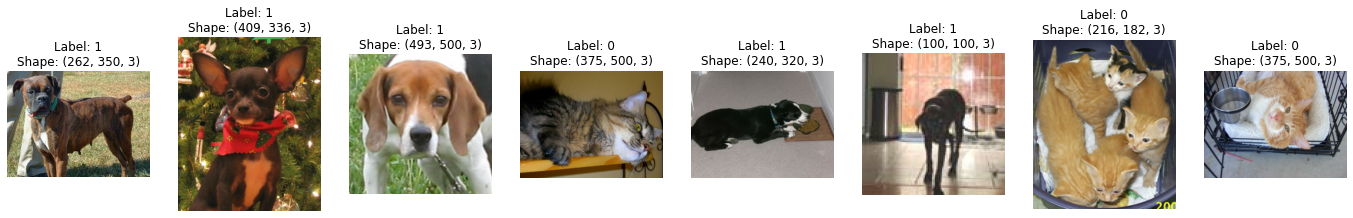

In [4]:
num_samples = 8
index = 1
plt.figure(figsize=(24,4))
for x,y in dataset_train_original.take(num_samples):
  plt.subplot(1,8,index)
  plt.imshow(x.numpy())
  plt.title(f"Label: {y.numpy()}\nShape: {x.numpy().shape}")
  plt.axis("off")
  index += 1

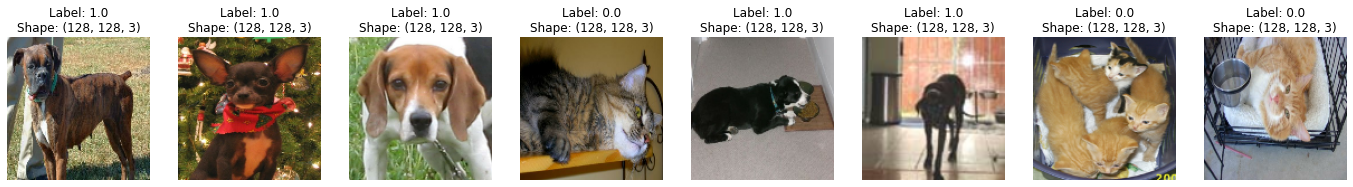

In [5]:
def encode(image,label,image_size=(128,128)):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.resize(image, image_size) #this can be a relatively costly process, so cache'ing is a very good idea here
  label = tf.cast(label, tf.float32)
  return image,label

dataset = dataset_train_original.map(lambda image,label: encode(image,label))

num_samples = 8
index = 1
plt.figure(figsize=(24,4))
for x,y in dataset.take(num_samples):
  plt.subplot(1,8,index)
  plt.imshow(x.numpy())
  plt.title(f"Label: {y.numpy()}\nShape: {x.numpy().shape}")
  plt.axis("off")
  index += 1

In [6]:
#Pipeline for preprocessing, cacheing, shuffling, batching 
dataset_train = dataset_train_original.map(lambda image,label: encode(image,label))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.map(lambda image,label: encode(image,label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)

In [7]:
history_dict = {}
epochs = 20

def render_history(history):
    plt.title("Losses")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Accuracies")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

def compare_histories():
  for training_name,history in history_dict.items():
    print(f'plotting val_accuracy of model: {training_name}')
    plt.plot(history["val_accuracy"],label=training_name)
    plt.legend()
  plt.show()
  plt.close()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

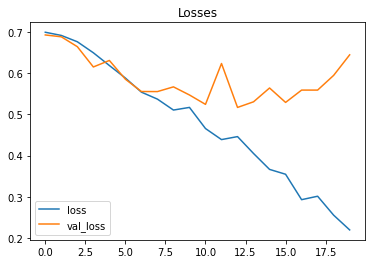

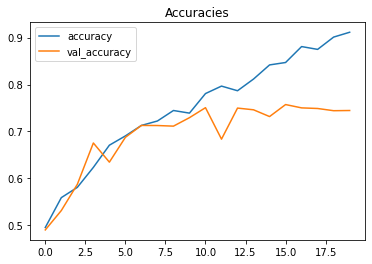

plotting val_accuracy of model: baseline


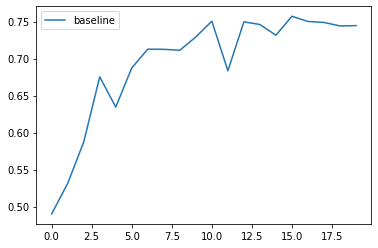

In [8]:
model = models.Sequential()

model.add(layers.Conv2D(
    32,
    (3 ,3),
    padding = "same", #same refers to same shape, not same data (0's are added)
    activation = "relu",
    input_shape=(128, 128, 3) 
))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_validate
)

history_dict["baseline"] = history.history
render_history(history)
compare_histories()

This result (high accuracy in training, low in validation) suggests we need more input data. In case we don't have any more data, we can try doing data augmentation

# Data Augmentation

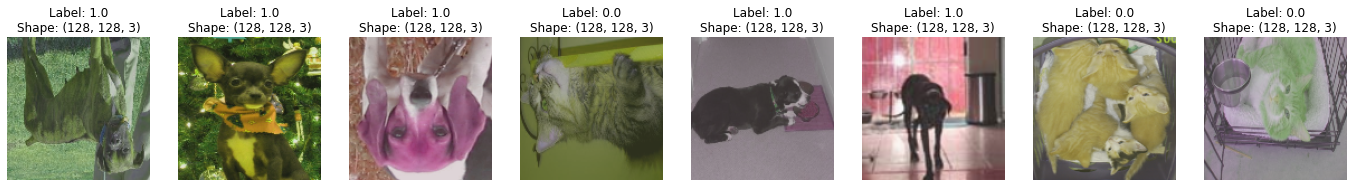

In [9]:
def augment(image,label):
  image_augmented = image
  image_augmented = tf.image.random_flip_left_right(image_augmented)
  image_augmented = tf.image.random_flip_up_down(image_augmented)
  image_augmented = tf.image.random_contrast(image_augmented,0.5,1.0)
  image_augmented = tf.image.random_hue(image_augmented,0.2)
  return image_augmented, label

dataset = dataset_train_original.map(lambda image,label: encode(image,label))
dataset = dataset.map(lambda image, label: augment(image,label))

num_samples = 8
index = 1
plt.figure(figsize=(24,4))
for x,y in dataset.take(num_samples):
  plt.subplot(1,8,index)
  plt.imshow(x.numpy())
  plt.title(f"Label: {y.numpy()}\nShape: {x.numpy().shape}")
  plt.axis("off")
  index += 1

In [10]:
#Pipeline for preprocessing, cacheing, shuffling, batching 
dataset_train_encoded = dataset_train_original.map(lambda image,label: encode(image,label))
dataset_train_encoded_cached = dataset_train_encoded.cache()
dataset_train_EC_augmented = dataset_train_encoded_cached.map(lambda image,label: augment(image,label))
dataset_train_EC_augmented = dataset_train_EC_augmented.shuffle(2500)
dataset_train_augmented = dataset_train_EC_augmented.batch(128)

# We shouldn't do augmentation on the validation data (it would be like shooting a moving target)
# And all the encoding cache'ing etc was done before, so we don't need to do it again
# dataset_validate = dataset_validate_original.map(lambda image,label: encode(image,label))
# dataset_validate = dataset_validate.cache()
# dataset_validate = dataset_validate.batch(128)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

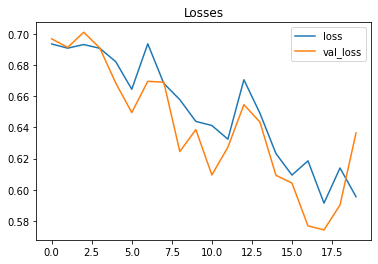

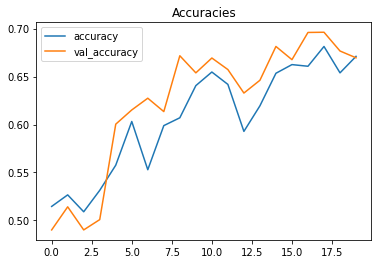

plotting val_accuracy of model: baseline
plotting val_accuracy of model: baseline_augmented


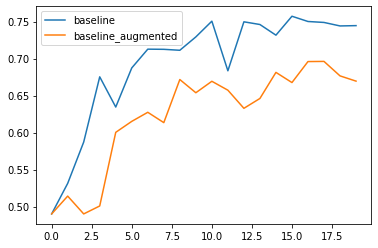

In [11]:
tf.keras.backend.clear_session() #this is to free-up the gpu memory

model = models.Sequential()

model.add(layers.Conv2D(
    32,
    (3 ,3),
    padding = "same", #same refers to same shape, not same data (0's are added)
    activation = "relu",
    input_shape=(128, 128, 3) 
))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    epochs = epochs,
    validation_data = dataset_validate
)

history_dict["baseline_augmented"] = history.history
render_history(history)
compare_histories()

Apparently, augmentation did not solve the problem. Let's try some dropout regularization.
# Dropout

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0

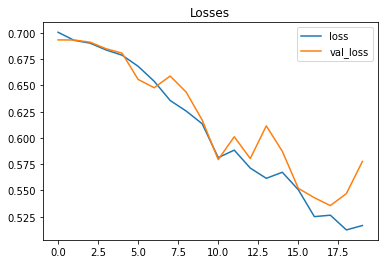

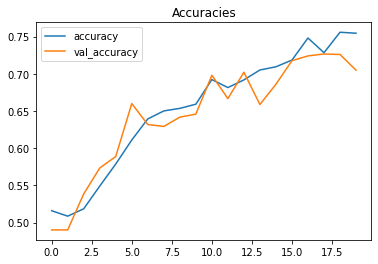

plotting val_accuracy of model: baseline
plotting val_accuracy of model: baseline_augmented
plotting val_accuracy of model: baseline_dropout


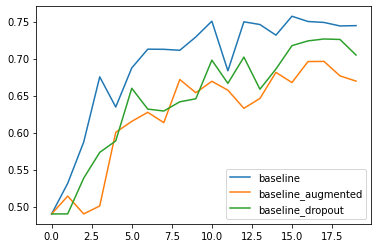

In [12]:
tf.keras.backend.clear_session() #this is to free-up the gpu memory

model = models.Sequential()

model.add(layers.Conv2D(
    32,
    (3 ,3),
    padding = "same", #same refers to same shape, not same data (0's are added)
    activation = "relu",
    input_shape=(128, 128, 3) 
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_validate
)

history_dict["baseline_dropout"] = history.history
render_history(history)
compare_histories()

#TRANSFER LEARNING

In [13]:
tf.keras.backend.clear_session()

base_net = tf.keras.applications.VGG19()
base_net.summary()

574710816/574710816 [==============================] - 25s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [17]:
#the original model's input and output layers do not match, first fix that
base_net = tf.keras.applications.VGG19(
    include_top = False, #remove the top (end) part of the model (e.g., flatten )
    input_shape = (128,128,3) #our input size
)
base_net.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 22s 915ms/step - loss: 0.9905 - accuracy: 0.6148 - val_loss: 0.5637 - val_accuracy: 0.6885
Epoch 2/20
19/19 [=====

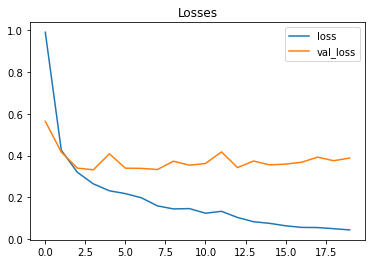

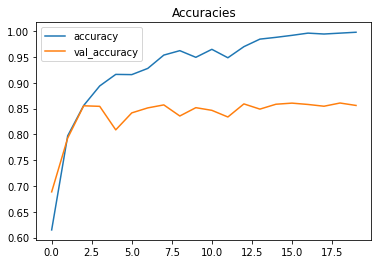

plotting val_accuracy of model: baseline
plotting val_accuracy of model: baseline_augmented
plotting val_accuracy of model: baseline_dropout
plotting val_accuracy of model: vgg19


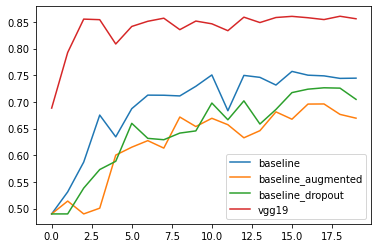

In [19]:
# add a suitable dense leyer and activation on top
base_net.trainable = False #so that these parameters will be frozen in our model

model = models.Sequential()
model.add(base_net) #block5_pool (MaxPooling2D)  (None, 4, 4, 512)  this shape is the output of the base_net  
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))       
model.summary()


model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_validate
)

history_dict["vgg19"] = history.history
render_history(history)
compare_histories()

Significant improvement! 
Try a different model!

In [26]:
#the original model's input and output layers do not match, first fix that
base_net = tf.keras.applications.InceptionResNetV2(
    include_top = False, #remove the top (end) part of the model (e.g., flatten)
    input_shape = (128,128,3) #our input size
)
base_net.summary()

219055592/219055592 [==============================] - 10s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_203 (Batch  (None, 63, 63, 32)  96          ['conv2d_203[0][0]']             
 Normalization)                                                                                   
            

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 128)               786560    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 55,123,425
Trainable params: 786,689
Non-trainable params: 54,336,736
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 26s 810ms/step - loss: 2.1874 - accuracy: 0.8169 - v

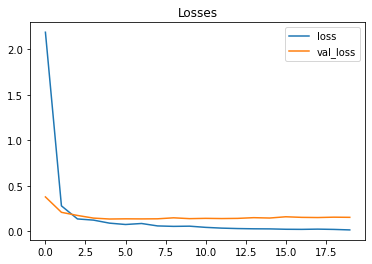

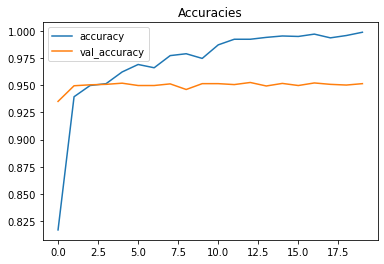

plotting val_accuracy of model: baseline
plotting val_accuracy of model: baseline_augmented
plotting val_accuracy of model: baseline_dropout
plotting val_accuracy of model: vgg19
plotting val_accuracy of model: EffNetV2M


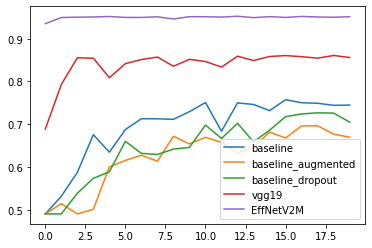

In [27]:
# add a suitable dense leyer and activation on top
base_net.trainable = False #so that these parameters will be frozen in our model

model = models.Sequential()
model.add(base_net) #top_activation (Activation)    (None, 4, 4, 1280):  this shape is the output of the base_net  
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))       
model.summary()


model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_validate
)

history_dict["EffNetV2M"] = history.history
render_history(history)
compare_histories()

Even better!!
Another try: same model but larger image size:

In [31]:
def encode(image,label,image_size=(256,256)):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.resize(image, image_size) #this can be a relatively costly process, so cache'ing is a very good idea here
  label = tf.cast(label, tf.float32)
  return image,label

#Pipeline for preprocessing, cacheing, shuffling, batching 
dataset_train256 = dataset_train_original.map(lambda image,label: encode(image,label))
dataset_train256 = dataset_train256.cache()
dataset_train256 = dataset_train256.shuffle(2500)
dataset_train256 = dataset_train256.batch(128)

dataset_validate256 = dataset_validate_original.map(lambda image,label: encode(image,label))
dataset_validate256 = dataset_validate256.cache()
dataset_validate256 = dataset_validate256.batch(128)

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_812 (Conv2D)            (None, 127, 127, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_812 (Batch  (None, 127, 127, 32  96         ['conv2d_812[0][0]']             
 Normalization)                 )                                               

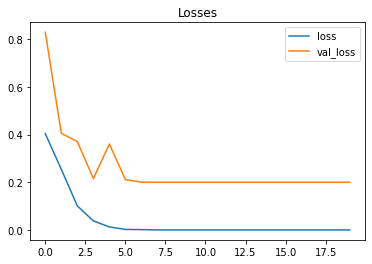

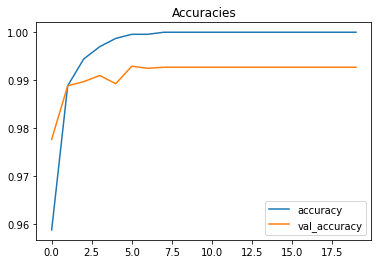

plotting val_accuracy of model: baseline
plotting val_accuracy of model: baseline_augmented
plotting val_accuracy of model: baseline_dropout
plotting val_accuracy of model: vgg19
plotting val_accuracy of model: EffNetV2M
plotting val_accuracy of model: ResNet152V2_shape256


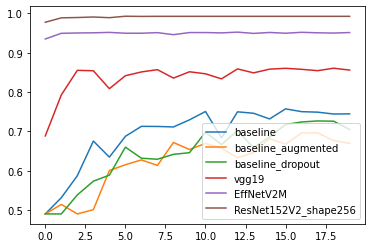

In [33]:
#the original model's input and output layers do not match, first fix that
base_net = tf.keras.applications.InceptionResNetV2(
    include_top = False, #remove the top (end) part of the model (e.g., flatten)
    input_shape = (256,256,3) #our input size
)
base_net.summary()

# add a suitable dense leyer and activation on top
base_net.trainable = False #so that these parameters will be frozen in our model

model = models.Sequential()
model.add(base_net) #top_activation (Activation)    (None, 4, 4, 1280):  this shape is the output of the base_net  
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))       
model.summary()


model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    dataset_train256,
    epochs = epochs,
    validation_data = dataset_validate256
)

history_dict["ResNet152V2_shape256"] = history.history
render_history(history)
compare_histories()

.9927 accuracy is *very* acceptable :-)